In [1]:
import pandas as pd

word_freq = pd.read_csv('google-1gram-spanish-freq.tsv', sep='\t', names=['palabra', 'frecuencia'])
word_freq.index = word_freq.index + 1

In [2]:
word_freq.head(10)

# Como es de esperar, palabras funcionales.

,palabra,frecuencia
1,de,5111675592
2,la,2957256540
3,y,2049362776
4,en,2011069460
5,que,1980171076
6,el,1972925179
7,los,1277631826
8,a,1240879750
9,del,960774040
10,se,893914677


In [3]:
word_freq.tail(10)

# La data de google-ngram viene ordenada alfabéticamente, y la frecuencia mínima
# que recoge es 40 para todos los años. Palabras mal escritas, e.g. zaptistas
# (zapatistas?), zamicnto; algunos nombres (zuburi es apellido). Solo hay dos que
# parecen palabras del español: zurrándome y zurciéndose; y zabullian efectivamente
# es palabra que se usa en Don Quijote.

,palabra,frecuencia
2209933,zizanias,40
2209934,zurrándome,40
2209935,zuburi,40
2209936,zumientos,40
2209937,zamicnto,40
2209938,zurciéndose,40
2209939,zaptistas,40
2209940,zuramente,40
2209941,zarparla,40
2209942,zabullian,40


In [4]:
# Cantidad de tipos

len(word_freq)

2209942

In [5]:
# Cantidad de tokens

sum(word_freq[:]['frecuencia'])

69668088661

In [6]:
# Tenemos 2,2 millones de tipos y 69 mil millones de tokens. Sabemos que el final
# de la lista tiene muchas cadenas de caracteres que no son realmente palabras,
# así que cortemos la lista. El corte es arbitrario, y diferentes expertos eligirán
# diferentes puntos de corte, pero la idea es cortar en algún lugar donde la
# proporción de palabras/no-palabras ya no sea aceptable.

word_freq.drop(word_freq.index[100000:], inplace=True)
word_freq.tail(20)

,palabra,frecuencia
99981,caracterizarla,15219
99982,itu,15219
99983,karate,15219
99984,pardillo,15219
99985,resignarme,15219
99986,strictu,15219
99987,vist,15219
99988,arrastren,15218
99989,muriéndose,15218
99990,yahualica,15218


In [7]:
# Mucho mejor. Hay algunas palabras en inglés, otras que deben ser error
# ortográfico o nombres, pero casi todas son palabras del español. Esto
# nos deja con 100,000 tipos, y la siguiente cantidad de tokens.

sum(word_freq[:]['frecuencia'])

# Quedamos con solo mil millones menos (68 mil millones), ya que descartamos
# tipos de baja frecuencia. Pero bajamos los tipos de 2,2 millones a 100,000.

68004557656

In [8]:
# Palabras más frecuentes, ignorando palabras funcionales. Se ignoran también
# algunas palabras de clase abierta muy frecuentes, incluidas en la lista de
# de paro de NLTK.

from nltk.corpus import stopwords

sw = stopwords.words('spanish')
word_freq[~word_freq.palabra.isin(sw)].head(20)

,palabra,frecuencia
27,á,149129216
32,si,130264550
36,ser,104335790
41,dos,86119272
44,parte,81981169
50,puede,72848333
51,mismo,72382435
53,general,69931076
56,así,68063059
57,años,68017055


La conjunción "y" escrita como "i" se usaba al menos hasta fines del
siglo XIX, por ejemplo en la Historia General de Chile de Barros
Arana publicada entre 1884-1902. La preposición "a" con acento no
tengo idea, veamos Google Ngrams.

![alt text](google_ngrams_preposicion_a.png "Title")

Alrededor de 1907-08 empezó el cambio de ortografía, proceso que duró
hasta 1922-23.

In [9]:
# Vamos a sumar la frecuencia de "i" a "y", y de "á" a "a", que suena muy
# confuso. Luego borraremos "á" e "i", y re-ordenaremos y re-indexaremos
# los datos. De esta manera tendremos una idea más precisa del uso de
# estas palabras independientemente de su ortografía. También borramos
# un NaN que hay por ahí.

word_freq.loc[8, 'frecuencia'] = sum(word_freq[word_freq.palabra.isin(['a', 'á'])]['frecuencia'])
word_freq.loc[3, 'frecuencia'] = sum(word_freq[word_freq.palabra.isin(['y', 'i'])]['frecuencia'])
word_freq.drop([27, 71], inplace=True)
word_freq.drop(word_freq[pd.isnull(word_freq).any(axis=1)].index, inplace=True)
word_freq.sort_values(by=['frecuencia'], ascending=False, inplace=True)
word_freq.reset_index(drop=True, inplace=True)
word_freq.index = word_freq.index + 1

In [10]:
# Veamos la proporción de la frecuencia de las palabras (o tipos) y el
# número total de tokens.

word_freq['%'] = word_freq['frecuencia'].transform(lambda r: round(r/r.sum(),4)*100)
word_freq.head(10)

# 1 de cada diez palabras es "de" o "la", y una de cada 5 palabras es 
# "de", "la", "y", "en" o "que".

,palabra,frecuencia,%
1,de,5111675592,7.52
2,la,2957256540,4.35
3,y,2106018664,3.10
4,en,2011069460,2.96
5,que,1980171076,2.91
6,el,1972925179,2.90
7,a,1390008966,2.04
8,los,1277631826,1.88
9,del,960774040,1.41
10,se,893914677,1.31


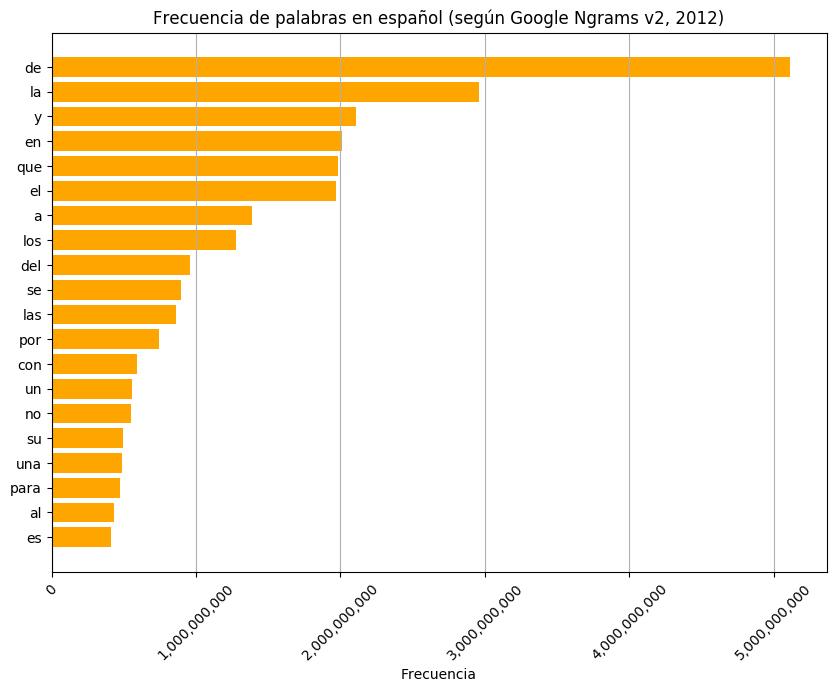

In [11]:
# Grafiquemos la frecuencia de las palabras.

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

plt.rcdefaults()
plt.rcParams["figure.figsize"] = [10, 7]

fig, ax = plt.subplots()
plt.xticks(rotation=45)

top_n = 20
top_words = word_freq['palabra'][:top_n].tolist()
y_pos = np.arange(len(top_words))
top_freqs = np.array(word_freq['frecuencia'][:top_n].tolist())

ax.barh(y_pos, top_freqs, 0.8, align='center', color='orange', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_words)
ax.invert_yaxis()
ax.set_xlabel('Frecuencia')
ax.set_title('Frecuencia de palabras en español (según Google Ngrams v2, 2012)')
ax.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(axis='x')
plt.show()

# Se parece, más o menos, a una distribución de Zipf.
# TODO: graficar Zipf encima.
# freq("la") = 0.5 * freq("de"), freq("y") = 0.33 * freq("de"), etc.
# TODO: mostrar la frecuencia exacta al lado de la barra y deshacerse
# del grid de fondo.

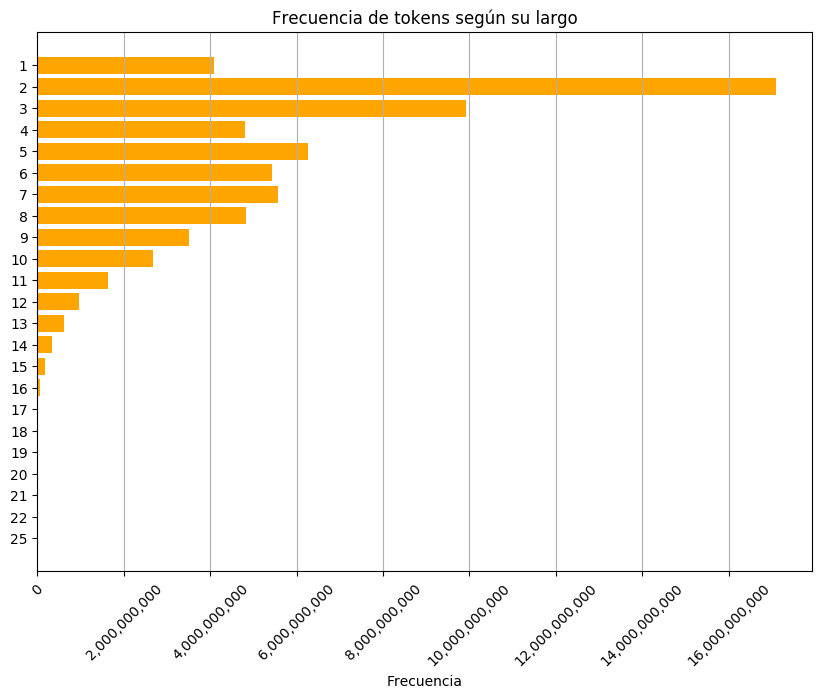

In [12]:
# Veamos el largo de los tokens

from collections import defaultdict

word_length_freqs = defaultdict(int)
word_length_types = defaultdict(list)

for _i, row in word_freq.iterrows():
    word_length_freqs[len(row['palabra'])] += row['frecuencia']
    word_length_types[len(row['palabra'])].append(row['palabra'])

plt.rcdefaults()
plt.rcParams["figure.figsize"] = [10, 7]

fig, ax = plt.subplots()
plt.xticks(rotation=45)

lengths, length_freqs = zip(*sorted(word_length_freqs.items(), key=lambda x: x[0]))
y_pos = np.arange(len(lengths))

ax.barh(y_pos, length_freqs, 0.8, align='center', color='orange', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(lengths)
ax.invert_yaxis()
ax.set_xlabel('Frecuencia')
ax.set_title('Frecuencia de tokens según su largo')
ax.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(axis='x')
plt.show()

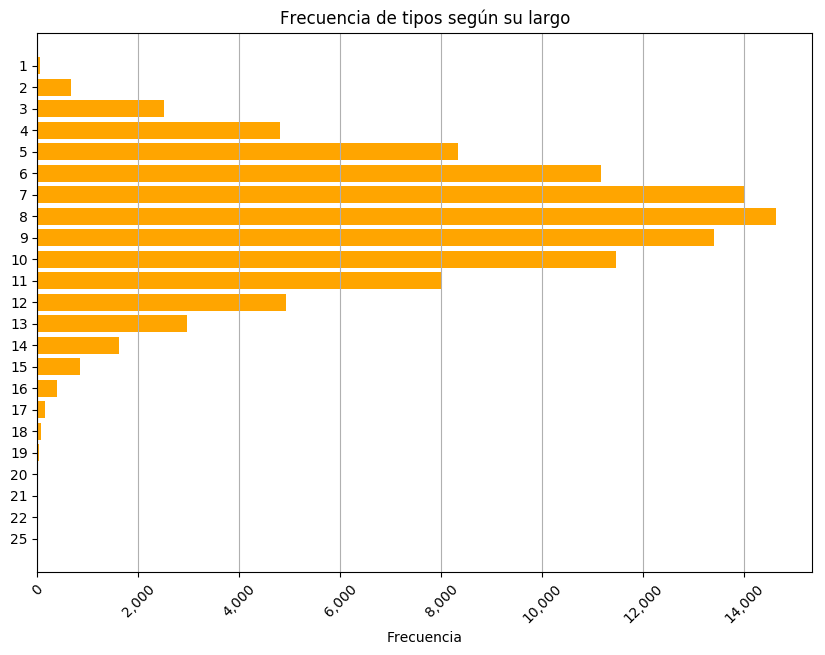

In [13]:
# ... y el largo de los tipos

plt.rcdefaults()
plt.rcParams["figure.figsize"] = [10, 7]

fig, ax = plt.subplots()
plt.xticks(rotation=45)

lengths, length_types = zip(*sorted(word_length_types.items(), key=lambda x: x[0]))
length_num_types = [len(ts) for ts in length_types]
y_pos = np.arange(len(lengths))

ax.barh(y_pos, length_num_types, 0.8, align='center', color='orange', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(lengths)
ax.invert_yaxis()
ax.set_xlabel('Frecuencia')
ax.set_title('Frecuencia de tipos según su largo')
ax.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(axis='x')
plt.show()

In [14]:
# ¿Cuáles son esas palabras más largas?

from IPython.display import HTML, display

inner_table = ""
for i in (20, 21, 22, 25):
    inner_table += '<tr><td align="center">{}</td><td align="center">{}</td></tr>'.format(
        i, ', '.join(word_length_types[i]))

display(HTML(
    """<table>
         <tr>
           <td align="center"><b>largo</b></td>
           <td align="left"><b>palabras</b></td>
         </tr>{}
       </table>""".format(inner_table)
))

# "contencioso administrativo" es un término legal que frecuentemente se une con un guión.
# ¿Quizás el guión sea mal interpretado cuando coincide con guión para salto de página?

largo,palabras
20,"inconstitucionalidad, institucionalización, internacionalización, intergubernamentales, transnacionalización, interinstitucionales, extraterritorialidad, desindustrialización, otorrinolaringología, circunstanciadamente, correspondientemente, anticonstitucionales, antirreeleccionistas"
21,"contrarrevolucionaria, contrarrevolucionario, desproporcionadamente, interdisciplinariedad, constitucionalización, desterritorialización"
22,"contrarrevolucionarios, contrarrevolucionarias"
25,"contenciosoadministrativo, contenciosoadministrativa"


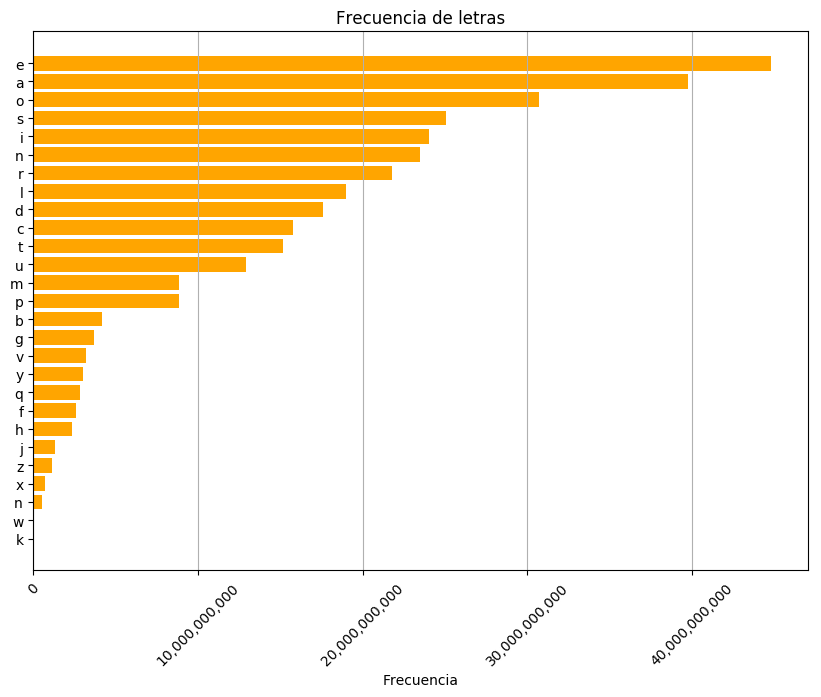

In [15]:
# Frecuencia de letras

characters = 'qwertyuiopasdfghjklñzxcvbnmáéíóúü'
diacritics = 'áéíóúü'
diac2base = {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u'}

freq_chars_base = defaultdict(int)

for _i, row in word_freq.iterrows():
    for char in row['palabra']:
        if char in characters:
            if char in diacritics:
                freq_chars_base[diac2base[char]] += row['frecuencia']
            else:
                freq_chars_base[char] += row['frecuencia']
                
plt.rcdefaults()
plt.rcParams["figure.figsize"] = [10, 7]

fig, ax = plt.subplots()
plt.xticks(rotation=45)

chars, char_freqs = zip(*sorted(freq_chars_base.items(), key=lambda x: x[1], reverse=True))
y_pos = np.arange(len(chars))

ax.barh(y_pos, char_freqs, 0.8, align='center', color='orange', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(chars)
ax.invert_yaxis()
ax.set_xlabel('Frecuencia')
ax.set_title('Frecuencia de letras')
ax.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(axis='x')
plt.show()

# Muy bien, ahí están las frecuencias de las letras colapsando los diacríticos a
# su letra base. Pero, ¿cuál es el ETAOIN SRHLDCU para el español? No encontré
# información sobre el orden de los tipos móviles en sus cajas. 🐬 ayúdameeee.